## Part 1: Importing and cleaning the Seattle, Washington Dataframe

In [13]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

In [14]:
# Assigning the url of interest to a variable and creatinge a response object
url = "https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Seattle"
response = requests.get(url).text

In [15]:
# Scraping the table from the wikipedia webpage, and then re-organizing the data into a dataframe
soup = BeautifulSoup(response,'lxml')
Seattle_Neighborhoods = soup.find('table',{'class':'wikitable sortable'})
table_rows = Seattle_Neighborhoods.find_all('tr')
data = []
for row in table_rows:
    data.append([t.text.strip() for t in row.find_all('td')])

df = pd.DataFrame(data, columns= ['Neighborhood Name', 'Within Larger District', "Annexed", "Locator Map", "Street Map", "Image", "Notes"])

In [16]:
## This dataframe is messy and will require a lot of cleaning
df.head()

,Neighborhood Name,Within Larger District,Annexed,Locator Map,Street Map,Image,Notes
0,None,None,None,None,None,None,None
1,North Seattle,Seattle,Various,,,,North of the Lake Washington Ship Canal[42]
2,Broadview,North Seattle[42],1954[43],,,,[44]
3,Bitter Lake,North Seattle[42],1954[43],,,,[45]
4,North Beach / Blue Ridge,North Seattle[42],"1940,[43] 1954[43]",,,,[46]


In [17]:
## Cleaning the dataframe by dropping unnecessary columns
df.drop(["Annexed", "Locator Map", "Street Map", "Image", "Notes", 'Within Larger District'], axis=1, inplace=True)

In [18]:
## Dropping rows that contain a null value in the Neighborhood Name column
df.dropna(inplace=True)

In [19]:
##1 row was dropped
df.shape

(127, 1)

In [20]:
### The Neighborhood Name column contains values with a lot of characters that will interfere with the API calls, so we must clean all of this up one step at a time
### First we convert the Neighborhood Name values to a list to make it easier to work with. Then we iterate over the list and split when there is a / character
neighborhood_fixed = []
for i in df['Neighborhood Name']:
    i = i.split("/")[0]
    neighborhood_fixed.append(i)

In [21]:
### Now if there is a space at the end, we slice that particular value to not include the space.
neighborhood_fixed_2 = []
for i in neighborhood_fixed:
    if i[-1] == " ":
        neighborhood_fixed_2.append(i[:-1])
    else:
        neighborhood_fixed_2.append(i)

In [22]:
### To remove the bracketed numbers, we iterate over the list so that if the number is a 3 digit number, we slice to not include the last 5 characters ie [123]. If a 2 digit number, we do the same but for the last 4.
neighborhood_fixed_3 = []
for i in neighborhood_fixed_2:
    if len(i) > 5:
        if i[-5] == '[':
            neighborhood_fixed_3.append(i[:-5])
        elif i[-4] == '[':
            neighborhood_fixed_3.append(i[:-4])
        else:
            neighborhood_fixed_3.append(i)
    else:
        neighborhood_fixed_3.append(i)

In [23]:
### Some of the values had an explicit newline character, which we remove here
neighborhood_fixed_4 = []
for i in neighborhood_fixed_3:
    i = i.split("\n")[0]
    neighborhood_fixed_4.append(i)

In [24]:
### Some of the values had an alternative name in parentheses, which we remove here
neighborhood_fixed_5 = []
for i in neighborhood_fixed_4:
    i = i.split(" (")[0]
    neighborhood_fixed_5.append(i)

In [25]:
df['Neighborhood'] = neighborhood_fixed_5

In [26]:
df.head()

,Neighborhood Name,Neighborhood
1,North Seattle,North Seattle
2,Broadview,Broadview
3,Bitter Lake,Bitter Lake
4,North Beach / Blue Ridge,North Beach
5,Crown Hill,Crown Hill


In [27]:
### There are some neighborhoods which yielded no coordinates, even with no odd characters in them. These were manually looked up and replaced as needed.
Neighborhoods_To_Replace = ['North College Park', 'Central Waterfront', 'Renton Hill', 'Mid Beacon Hill', 'Industrial District']
Replacement_Neighborhoods = ['Licton Springs', 'Pike Place Market', 'Capitol Hill', 'Beacon Hill', 'Industrial']
df.replace(Neighborhoods_To_Replace, Replacement_Neighborhoods, inplace=True)

In [28]:
df.drop(['Neighborhood Name'], axis=1, inplace=True)

In [29]:
df.reset_index(drop=True, inplace=True)

In [30]:
df.head()

,Neighborhood
0,North Seattle
1,Broadview
2,Bitter Lake
3,North Beach
4,Crown Hill


## Part 2: Finding latitude and longitude for the neighborhoods in the Seattle dataframe

In [31]:
!pip install geocoder

     |████████████████████████████████| 102kB 14.8MB/s ta 0:00:01


In [32]:
### we iterate over the values in the Neighborhood column, and append the coordinates we get from making calls to geocoder using those Neighborhood Names to the list 'coord_list'
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="Seattle_Explorer", timeout=3)

coord_list = []

for i in df['Neighborhood']:
    g = geolocator.geocode('{}, Seattle, Washington'.format(i))
    coord_list.append(g)

In [33]:
### Some names were invalid and returned None, which we replaced with the string "None" followed by coordinates of 0,0 to make iterating over the list easier
None_list = [("None", (0, 0)) if v is None else v for v in coord_list]

In [34]:
## All of the (lat,Long) pairs were appended to their own list
coords = []
for i in None_list:
    coords.append(i[1])

In [35]:
## The coordinate pairs were stripped into their respective latitude and longitude values
latitude = []
longitude = []
for i in coords:
    latitude.append(i[0])
    longitude.append(i[1])

In [36]:
## These lat and Long values were turned into dataframe columns
df['Latitude'] = latitude
df['Longitude'] = longitude

In [37]:
## Subsetting the dataframe to exclude any neighborhoods unable to return coordinates for
df = df[df['Latitude'] != 0.000000]

In [38]:
df.head()

,Neighborhood,Latitude,Longitude
0,North Seattle,47.660773,-122.291497
1,Broadview,47.722320,-122.360407
2,Bitter Lake,47.726236,-122.348764
3,North Beach,47.696210,-122.392362
4,Crown Hill,47.694715,-122.371459


## Mapping out the Seattle Neighborhoods

In [39]:
!pip install folium

     |████████████████████████████████| 92kB 11.9MB/s eta 0:00:01


In [40]:
import folium

In [41]:
## Get Coordinates for Seattle to center the folium map
address = 'Seattle, WA'

geolocator = Nominatim(user_agent="Washington_Explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Seattle are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Seattle are 47.6038321, -122.3300624.


In [42]:
# create map of Seattle using latitude and longitude values
map_Seattle = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Seattle)  
    
map_Seattle

## Part 4: Making API calls to the foursquare API to find venues within each neighborhood

In [43]:
# The code was removed by Watson Studio for sharing.

In [44]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [45]:
Seattle_Venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

North Seattle
Broadview
Bitter Lake
North Beach
Crown Hill
Greenwood
Northgate
Haller Lake
Pinehurst
Licton Springs
Maple Leaf
Lake City
Cedar Park
Matthews Beach
Meadowbrook
Olympic Hills
Victory Heights
Wedgwood
View Ridge
Sand Point
Roosevelt
Ravenna
Bryant
Windermere
Hawthorne Hills
Laurelhurst
University District
University Village
Wallingford
Northlake
Green Lake
Fremont
Phinney Ridge
Ballard
Whittier Heights
Adams
Sunset Hill
Loyal Heights
Central Seattle
Magnolia
Lawton Park
Briarcliff
Southeast Magnolia
Interbay
Queen Anne
North Queen Anne
East Queen Anne
Lower Queen Anne
West Queen Anne
Capitol Hill
Portage Bay
Broadway
Montlake
Stevens
Interlaken
Madison Valley
Capitol Hill
Madison Park
Broadmoor
Lake Union
South Lake Union, Seattle
Cascade, Seattle
Westlake
Eastlake
Downtown
Denny Triangle
Belltown
Pike-Market
Central Business District
First Hill
Pioneer Square
International District
Yesler Terrace
Pike Place Market
Central Area
Mann
Minor
Atlantic
Judkins Park
Madrona
Madr

In [46]:
Seattle_Venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North Seattle,47.660773,-122.291497,Center for Urban Horticulture,47.657978,-122.290237,College Science Building
1,North Seattle,47.660773,-122.291497,University Village,47.662487,-122.298531,Shopping Plaza
2,North Seattle,47.660773,-122.291497,Din Tai Fung 鼎泰豐,47.661567,-122.299725,Dumpling Restaurant
3,North Seattle,47.660773,-122.291497,Rachel's Ginger Beer,47.662506,-122.299758,Restaurant
4,North Seattle,47.660773,-122.291497,Molly Moon's Homemade Ice Cream,47.661702,-122.299670,Ice Cream Shop


In [47]:
### The total number of venues returned
Seattle_Venues.shape

(11094, 7)

## Part 5: Clearing out duplicate entries in the dataframe of venues in Seattle


In [48]:
Seattle_Venues2 = Seattle_Venues.copy()

In [49]:
## Dropping duplicates that had identical Venue names, Venue Latitudes, and Venue Longitudes 
Seattle_Venues2.drop_duplicates(['Venue', 'Venue Latitude', 'Venue Longitude'], keep='first', inplace=True)

In [50]:
## Total number of unique venues in the dataframe
len(Seattle_Venues2)

2906

In [51]:
List_of_Venues = []
for i in Seattle_Venues2['Venue Category']:
    List_of_Venues.append(i)

In [52]:
## Creating arrays of venue categories with their counts
values, counts = np.unique(List_of_Venues, return_counts=True)

In [53]:
## Creating a ratio that is the number of each venue category divided by the total number of unique venues found
counts2 = counts/len(Seattle_Venues2)

In [54]:
counts2 = counts2 * 100

In [55]:
## Creating a new dataframe from the arrays
df_counts = pd.DataFrame({'Venues':values, 'Raw_Counts':counts, 'Ratio_Counts': counts2})

In [56]:
## Sorting the dataframe by the Ratio values descending
df_counts.sort_values(by=['Ratio_Counts'], ascending=False, inplace=True)

In [57]:
df_counts.head()

,Venues,Raw_Counts,Ratio_Counts
76,Coffee Shop,204,7.019959
232,Park,120,4.129387
241,Pizza Place,101,3.475568
27,Bar,70,2.408809
203,Mexican Restaurant,64,2.202340


In [58]:
df_counts.reset_index(drop=True, inplace=True)

In [59]:
df_counts.head()

,Venues,Raw_Counts,Ratio_Counts
0,Coffee Shop,204,7.019959
1,Park,120,4.129387
2,Pizza Place,101,3.475568
3,Bar,70,2.408809
4,Mexican Restaurant,64,2.202340


# Portland Oregon
## Part 6: Importing and cleaning the dataframe

In [60]:
# The code was removed by Watson Studio for sharing.

,OBJECTID,NAME,COMMPLAN,SHARED,COALIT,HORZ_VERT,MAPLABEL,ID,Shape_Length,Shape_Area
0,1,CATHEDRAL PARK,,,NPNS,HORZ,Cathedral Park,31,11434.254777,5.424298e+06
1,2,UNIVERSITY PARK,,,NPNS,HORZ,University Park,88,11950.859827,6.981457e+06
2,3,PIEDMONT,ALBINA,,NPNS,VERT,Piedmont,70,10849.327392,6.079530e+06
3,4,WOODLAWN,ALBINA,,NECN,HORZ,Woodlawn,93,8078.360994,3.870554e+06
4,5,CULLY ASSOCIATION OF NEIGHBORS,,,CNN,HORZ,Cully Association of Neighbors,23,18179.392090,1.658062e+07


In [61]:
df_data_1.shape

(98, 10)

In [62]:
## Dropping superfluous columns 
df_data_1.drop(["OBJECTID", "NAME", "COMMPLAN", "SHARED", "COALIT", "HORZ_VERT", "ID", "Shape_Length", "Shape_Area"], axis=1, inplace=True)

In [63]:
## Renameing the MAPLABEL column to Neighborhoods
df_data_1.rename(columns={'MAPLABEL':'Neighborhood'}, inplace=True)

In [64]:
### Some of the imported data had names of Neighborhood Associations instead of Neighborhood names, which did not yield coordinates when called with geocoder.
### Additionally the neighborhood association were in different formats ie 'association of neighbors', 'community association', so therefore it was easier to do this step manually
List_To_Replace = ['Parkrose Heights Association of Neighbors', 'Sunderland Association of Neighbors', 'Sabin Community Association', 'Centennial Community Association', 'Cully Association of Neighbors', 'Sumner Association of Neighbors', 'Buckman Community Association', 'Brooklyn Action Corps', 'Sellwood-Moreland Improvement League', 'Wilkes Community Group', 'Irvington Community Association', 'Hayden Island Neighborhood Network']
Replace_To = ['Parkrose Heights', 'Sunderland', 'Sabin', 'Centennial', 'Cully', 'Sumner', 'Buckman', 'Brooklyn', 'Sellwood-Moreland', 'Wilkes', "irvington", "Hayden Island"]
df_data_1.replace(List_To_Replace, Replace_To, inplace=True)

In [65]:
df_data_1.head()

,Neighborhood
0,Cathedral Park
1,University Park
2,Piedmont
3,Woodlawn
4,Cully


## Part 7: Finding location data for each neighborhood in Portland, and plotting the neighborhoods with folium

In [66]:
geolocator = Nominatim(user_agent="Portland_Explorer", timeout=3)

Portland_Coords = []

for i in df_data_1['Neighborhood']:
    g = geolocator.geocode('{}, Portland, Oregon'.format(i))
    Portland_Coords.append(g)

In [67]:
None_Portland = [("None", (0, 0)) if v is None else v for v in Portland_Coords]

In [68]:
coords2 = []
for i in None_Portland:
    coords2.append(i[1])

In [69]:
latitudep = []
longitudep = []
for i in coords2:
    latitudep.append(i[0])
    longitudep.append(i[1])

In [70]:
df_data_1['Latitude'] = latitudep
df_data_1['Longitude'] = longitudep

# Look at folium map and see if you should include these datapoints, do same for Seattle

In [71]:
## Subsetting the dataframe to only rows that had a valid Latitude value
df_data_1 = df_data_1[df_data_1['Latitude'] != 0.000000]

In [72]:
## Get Coordinates for Seattle to center the folium map
address = 'Portland, OR'

geolocator = Nominatim(user_agent="Portland_Explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Seattle are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Seattle are 45.5202471, -122.6741949.


In [73]:
# create map of Portland using latitude and longitude values
map_Portland = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(df_data_1['Latitude'], df_data_1['Longitude'], df_data_1['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Portland)  
    
map_Portland

## Part 8: Calling foursquare API to find venues near the neighborhoods in Portland

In [74]:
Portland_Venues = getNearbyVenues(names=df_data_1['Neighborhood'],
                                   latitudes=df_data_1['Latitude'],
                                   longitudes=df_data_1['Longitude']
                                  )

Cathedral Park
University Park
Piedmont
Woodlawn
Cully
Arbor Lodge
Overlook
Concordia
Parkrose
Sumner
Humboldt
King
Vernon
Northwest Heights
Rose City Park
Parkrose Heights
Russell
Pearl District
Woodland Park
Montavilla
Laurelhurst
Kerns
North Tabor
Glenfair
Buckman
Portland Downtown
Mt. Tabor
Sunnyside
South Portland
Homestead
South Tabor
Brooklyn
Creston-Kenilworth
Hillsdale
Foster-Powell
Mt. Scott-Arleta
Sellwood-Moreland
Hayhurst
Maplewood
Multnomah
Brentwood-Darlington
South Burlingame
Markham
Marshall Park
Collins View
West Portland Park
Arnold Creek
Far Southwest
Linnton
Sylvan-Highlands
Arlington Heights
Ashcreek
Crestwood
Ardenwald-Johnson Creek
Woodstock
Eastmoreland
Reed
Pleasant Valley
Centennial
Powellhurst-Gilbert
Lents
Hazelwood
Mill Park
Wilkes
Argay Terrace
Madison South
Roseway
Beaumont-Wilshire
Hollywood
Alameda
irvington
Sabin
Boise
Eliot
Bridlemile
Healy Heights
Sullivan's Gulch
Grant Park
Richmond
Forest Park
Hillside
St. Johns
Kenton
Sunderland
Portsmouth
Hayden

In [75]:
Portland_Venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cathedral Park,45.587636,-122.75864,Cathedral Park,45.587744,-122.759822,Park
1,Cathedral Park,45.587636,-122.75864,Occidental Wursthaus,45.588864,-122.761344,German Restaurant
2,Cathedral Park,45.587636,-122.75864,Taqueria Y Panaderia Santa Cruz,45.590201,-122.755332,Mexican Restaurant
3,Cathedral Park,45.587636,-122.75864,Occidental Brewing Company,45.588807,-122.761680,Brewery
4,Cathedral Park,45.587636,-122.75864,Hoplandia Beer,45.589662,-122.755614,Beer Store


In [76]:
Portland_Venues.shape

(7113, 7)

## Part 9: Dropping duplicate venues, creating 1 array for venue categories and another for their respective counts

In [77]:
Portland_Venues2 = Portland_Venues.copy()

In [78]:
Portland_Venues2 = Portland_Venues2.drop_duplicates(['Venue', 'Venue Latitude', 'Venue Longitude'])

In [79]:
len(Portland_Venues2)

2826

In [80]:
## Appending the Venue Categories in the Portland_Venues dataframe to a list
List_of_pVenues = []
for i in Portland_Venues2['Venue Category']:
    List_of_pVenues.append(i)

In [81]:
## Finding the counts for each Venue Type
pvalues, pcounts = np.unique(List_of_pVenues, return_counts=True)

In [82]:
## Using these counts of each Venue Category to create a ratio as a % of the total number of venues
pcounts2 = pcounts/len(Portland_Venues2) * 100

In [83]:
df_pcounts = pd.DataFrame({'Venues':pvalues, 'Raw_Counts':pcounts, 'Ratio_Counts': pcounts2})

In [84]:
df_pcounts = df_pcounts.sort_values(by=['Ratio_Counts'], ascending=False)

In [85]:
df_pcounts.reset_index(drop=True, inplace=True)

In [86]:
df_pcounts.head()

,Venues,Raw_Counts,Ratio_Counts
0,Coffee Shop,186,6.581741
1,Pizza Place,109,3.857042
2,Park,106,3.750885
3,Bar,102,3.609342
4,Mexican Restaurant,75,2.653928


In [87]:
## Appending all of the venue categories for the Portland and Seattle dataframes to a single list

total_venue_list = []
for i in df_counts['Venues']:
    total_venue_list.append(i)

for i in df_pcounts['Venues']:
    total_venue_list.append(i)

In [88]:
len(total_venue_list)

654

In [89]:
### Converting the list to a set to only show the unique venue categories
unique_venues = set(total_venue_list)

In [90]:
len(unique_venues)

398

## Part 10: Merging the Seattle and Oregon venue Dataframes, then replacing NaN values with 0 so calculations can be performed

In [91]:
## Merging the Seattle and Portland Venue Dataframes together
df_combined = pd.merge(df_counts, df_pcounts, how='outer', left_on = 'Venues', right_on = 'Venues')

In [92]:
df_combined.head()

,Venues,Raw_Counts_x,Ratio_Counts_x,Raw_Counts_y,Ratio_Counts_y
0,Coffee Shop,204.0,7.019959,186.0,6.581741
1,Park,120.0,4.129387,106.0,3.750885
2,Pizza Place,101.0,3.475568,109.0,3.857042
3,Bar,70.0,2.408809,102.0,3.609342
4,Mexican Restaurant,64.0,2.202340,75.0,2.653928


In [93]:
## Replacing all NaN Values with a 0
df_combined.fillna(0, inplace=True)

In [94]:
## Renaming the columns
df_combined.columns = ['Venues', 'Raw_Counts_Seattle', 'Ratio_Counts_Seattle', "Raw_Counts_Portland", "Ratio_Counts_Portland"]

In [95]:
df_combined.head()

,Venues,Raw_Counts_Seattle,Ratio_Counts_Seattle,Raw_Counts_Portland,Ratio_Counts_Portland
0,Coffee Shop,204.0,7.019959,186.0,6.581741
1,Park,120.0,4.129387,106.0,3.750885
2,Pizza Place,101.0,3.475568,109.0,3.857042
3,Bar,70.0,2.408809,102.0,3.609342
4,Mexican Restaurant,64.0,2.202340,75.0,2.653928


## Part 11: Writing a Z-test for 2 proportions function and looping it across the dataframe

In [96]:
import math
def ZTEST(p1, p2, n1=2906, n2=2826):
    p1 = p1/100
    p2 = p2/100 
    psub = (p1-p2)
    nadd = (1/n1 + 1/n2)
    pavg = ((p1*n2+p2*n2)/(n1+n2))
    pinv = (1-pavg)
    pdenom = (pavg * pinv * nadd)
    Z = psub/(math.sqrt(pdenom))
    return Z

In [97]:
list_p1 = df_combined['Ratio_Counts_Seattle']
list_p2 = df_combined['Ratio_Counts_Portland']

In [98]:
Z_list = []
for p1, p2 in zip(list_p1, list_p2):
    Z = ZTEST(p1, p2)
    Z_list.append(Z)

In [99]:
df_combined['Z_Score'] = Z_list

In [102]:
df_combined = df_combined.reindex(df_combined.Z_Score.abs().sort_values().index)

In [103]:
df_combined.head()

,Venues,Raw_Counts_Seattle,Ratio_Counts_Seattle,Raw_Counts_Portland,Ratio_Counts_Portland,Z_Score
12,Trail,38.0,1.307639,37.0,1.309271,-0.005473
305,Bed & Breakfast,1.0,0.034412,1.0,0.035386,-0.019880
282,Food Stand,1.0,0.034412,1.0,0.035386,-0.019880
277,Campground,1.0,0.034412,1.0,0.035386,-0.019880
270,Golf Driving Range,1.0,0.034412,1.0,0.035386,-0.019880


## Part 12: Segregating the Z-scores into 2 dataframes, using an alpha of 0.05

In [332]:
### Creating a dataframe where the magnitude of the Z_Score is greater than 1.96
df_combined_different = df_combined[abs(df_combined['Z_Score']) > 1.96]

In [333]:
df_combined_different = df_combined_different.reindex(df_combined_different.Z_Score.abs().sort_values().index)

In [336]:
df_combined_different

,Venues,Raw_Counts_Seattle,Ratio_Counts_Seattle,Raw_Counts_Portland,Ratio_Counts_Portland,Z_Score
148,Design Studio,4.0,0.137646,0.0,0.000000,2.000679
151,Outdoor Sculpture,4.0,0.137646,0.0,0.000000,2.000679
153,Gay Bar,4.0,0.137646,0.0,0.000000,2.000679
134,Library,4.0,0.137646,0.0,0.000000,2.000679
49,Bus Stop,14.0,0.481762,5.0,0.176929,2.028037
335,Street Food Gathering,0.0,0.000000,4.0,0.141543,-2.028819
22,Japanese Restaurant,28.0,0.963524,14.0,0.495400,2.096814
96,Airport Terminal,7.0,0.240881,1.0,0.035386,2.109023
7,Bakery,55.0,1.892636,34.0,1.203114,2.128888
13,Ice Cream Shop,38.0,1.307639,21.0,0.743100,2.135963


In [337]:
df_combined_similar = df_combined[(df_combined['Z_Score'] < 1.96) & (df_combined['Z_Score'] > -1.96)]

In [339]:
df_combined_similar.shape

(361, 6)

In [340]:
df_combined_similar = df_combined_similar[(df_combined_similar['Raw_Counts_Seattle'] > 8) | (df_combined_similar['Raw_Counts_Portland'] > 8)]

In [342]:
df_combined_similar.shape

(73, 6)

In [208]:
df_combined_similar = df_combined_similar[(df_combined_similar['Z_Score'] < 0.7) & (df_combined_similar['Z_Score'] > -0.7)]

In [211]:
df_combined_similar

,Venues,Raw_Counts_Seattle,Ratio_Counts_Seattle,Raw_Counts_Portland,Ratio_Counts_Portland,Z_Score
12,Trail,38.0,1.307639,37.0,1.309271,-0.005473
80,Indian Restaurant,9.0,0.309704,9.0,0.318471,-0.059724
75,Juice Bar,10.0,0.344116,10.0,0.353857,-0.062965
48,Taco Place,14.0,0.481762,14.0,0.495400,-0.074553
57,Salon / Barbershop,14.0,0.481762,14.0,0.495400,-0.074553
47,Marijuana Dispensary,15.0,0.516173,14.0,0.495400,0.111621
25,Gas Station,26.0,0.894701,24.0,0.849257,0.186307
32,Gym / Fitness Center,21.0,0.722643,19.0,0.672328,0.230439
39,Bank,18.0,0.619408,19.0,0.672328,-0.251808
36,Spa,19.0,0.653820,17.0,0.601557,0.252232


In [258]:
df_grouped = df_combined_similar.copy()

In [259]:
df_grouped['Z_Score'] = abs(df_grouped['Z_Score'])

In [261]:
df_grouped['Groupings'] = ''

In [262]:
Groupings_List = []
Food = ['Indian Restaurant', 'Taco Place', 'Farmers Market', 'Asian Restaurant',  'Burger Joint', 'BBQ Joint', 'Sushi Restaurant', 'Middle Eastern Restaurant', 'Chinese Restaurant']
Drink = ['Juice Bar', 'Brewery', 'Pub', 'Beer Bar', 'Cocktail Bar', 'Coffee Shop', 'Café']
Recreation = ['Trail', 'Marijuana Dispensary', 'Dog Run', 'Bookstore', 'Arts & Crafts Store', 'Lounge', 'Harbor / Marina']
Self_Care_and_Wellness = ['Gym / Fitness Center', 'Spa', 'Yoga Studio', 'Salon / Barbershop', 'Cosmetics Shop' ]
City_Essentials = ['Gas Station', 'Bank', 'Furniture / Home Store', 'Deli / Bodega' ]

for i in df_grouped['Venues']:
    if i in Food:
        Groupings_List.append('Food')
    elif i in Drink:
        Groupings_List.append('Drink')
    elif i in Recreation:
        Groupings_List.append('Recreation')
    elif i in Self_Care_and_Wellness:
        Groupings_List.append('Self Care and Wellness')
    else:
        Groupings_List.append('City Essentials')

In [263]:
df_grouped['Groupings'] = Groupings_List

In [264]:
df_food = df_grouped[df_grouped['Groupings'] == 'Food']  
df_drinks = df_grouped[df_grouped['Groupings'] == 'Drink']  
df_rec = df_grouped[df_grouped['Groupings'] == 'Recreation']  
df_wellness = df_grouped[df_grouped['Groupings'] == 'Self Care and Wellness']  
df_city = df_grouped[df_grouped['Groupings'] == 'City Essentials']  

In [265]:
df_food

,Venues,Raw_Counts_Seattle,Ratio_Counts_Seattle,Raw_Counts_Portland,Ratio_Counts_Portland,Z_Score,Groupings
80,Indian Restaurant,9.0,0.309704,9.0,0.318471,0.059724,Food
48,Taco Place,14.0,0.481762,14.0,0.495400,0.074553,Food
52,Farmers Market,14.0,0.481762,15.0,0.530786,0.263289,Food
41,Asian Restaurant,17.0,0.584997,15.0,0.530786,0.277424,Food
16,Burger Joint,36.0,1.238816,32.0,1.132343,0.374941,Food
42,BBQ Joint,17.0,0.584997,14.0,0.495400,0.465916,Food
28,Sushi Restaurant,25.0,0.860289,21.0,0.743100,0.500887,Food
102,Middle Eastern Restaurant,7.0,0.240881,9.0,0.318471,0.560032,Food
26,Chinese Restaurant,26.0,0.894701,30.0,1.061571,0.646275,Food


In [282]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

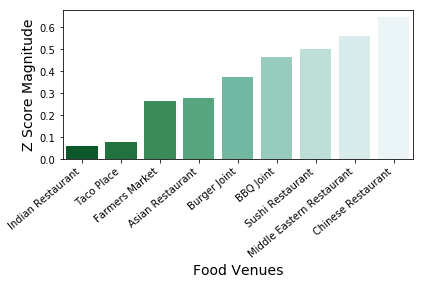

In [324]:
food_plot = sns.barplot(x='Venues',y='Z_Score',data=df_food, palette = "BuGn_r")
food_plot.set_xticklabels(food_plot.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
food_plot.set_xlabel("Food Venues",fontsize=14)
food_plot.set_ylabel("Z Score Magnitude",fontsize=14)
plt.show()

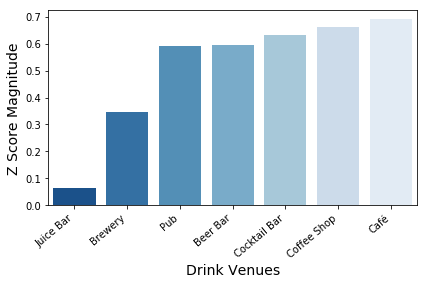

In [325]:
drink_plot = sns.barplot(x='Venues',y='Z_Score',data=df_drinks, palette="Blues_r")
drink_plot.set_xticklabels(drink_plot.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
drink_plot.set_xlabel("Drink Venues",fontsize=14)
drink_plot.set_ylabel("Z Score Magnitude",fontsize=14)
plt.show()

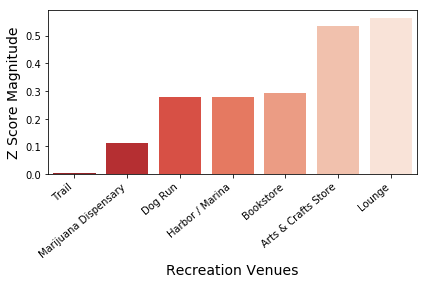

In [326]:
rec_plot = sns.barplot(x='Venues',y='Z_Score',data=df_rec, palette="Reds_r")
rec_plot.set_xticklabels(rec_plot.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
rec_plot.set_xlabel("Recreation Venues",fontsize=14)
rec_plot.set_ylabel("Z Score Magnitude",fontsize=14)
plt.show()

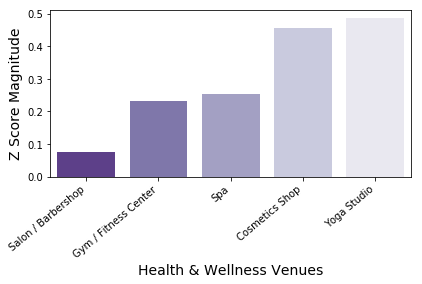

In [327]:
wellness_plot = sns.barplot(x='Venues',y='Z_Score',data=df_wellness, palette="Purples_r")
wellness_plot.set_xticklabels(wellness_plot.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
wellness_plot.set_xlabel("Health & Wellness Venues",fontsize=14)
wellness_plot.set_ylabel("Z Score Magnitude",fontsize=14)
plt.show()